In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging
import json
import random

import numpy as np
import json
from tqdm.notebook import tqdm


# Set-up

## Load data

In [3]:
# Load imagenet


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Get class names
imagenet_class_nums = np.arange(0, 1000, 1)
imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# # Load the ImageNet dataset
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)


# Patch/image-level analysis for maximally activating neurons

Look at maximally activating neurons with patch/image as the individual unit.

Loaded from precached activations from 500 randomly sampled ImageNet points.

In [4]:
import pandas as pd
import os

layer_num = 7

save_path = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
file_name = f'mlp_fc1_{layer_num}.npz'

loaded = pd.read_parquet(os.path.join(save_path, file_name))


### Get standard deviation of patch value 

On the neuron level (aggregating across all images and patches for that neuron)**

In [5]:
# Calculate mean and standard deviation for 'activation_value' grouped by 'neuron_idx'
grouped = loaded.groupby('neuron_idx')['activation_value']
mean_per_neuron = grouped.transform('mean')
std_dev_per_neuron = grouped.transform('std')

# Calculate the z-score (number of standard deviations from the mean)
loaded['activation_value_sds'] = (loaded['activation_value'] - mean_per_neuron) / std_dev_per_neuron

# Replace NaN and infinite values (which can occur if std_dev is zero) with zero
loaded['activation_value_sds'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)


# Sort by z-score
sorted_df = loaded.sort_values(by=['activation_value_sds'], ascending=False)

### Visualize heatmap for specific image + neuron

In [16]:
import pandas as pd


def plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224, pixel_num=14):

    activation_values_array = activation_values_array.reshape(pixel_num, pixel_num)

    # Create a heatmap overlay
    heatmap = np.zeros((image_size, image_size))
    patch_size = image_size // pixel_num

    for i in range(pixel_num):
        for j in range(pixel_num):
            heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values_array[i, j]

    # Plotting the image with the heatmap overlay
    fig, ax = plt.subplots()
    ax.imshow(image.permute(1,2,0))
    ax.imshow(heatmap, cmap='viridis', alpha=0.4)  # Overlaying the heatmap

    # Removing axes
    ax.axis('off')

    min_activation = activation_values_array.min()
    max_activation = activation_values_array.max()

    # Adding colorbar for the heatmap
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_activation, vmax=max_activation)), ax=ax, orientation='vertical')

    plt.title("Neuron {}'s Activation Values for Image {}".format(specific_neuron_idx, ""))
    plt.show()




In [17]:
def get_image_and_activations_by_id(specific_neuron_idx, specific_image_idx):
    image, label = load_specific_image(imagenet_data, random_indices, specific_image_idx)

    filtered_df = loaded[(loaded['batch_idx'] == specific_image_idx) & 
                                (loaded['neuron_idx'] == specific_neuron_idx)]

    activation_values = filtered_df['activation_value_sds']

    activation_values_array = activation_values.to_numpy()[1:]

    return image, activation_values_array


# Load saved indices
random_indices = np.load('imagenet_sample_indices.npy')

# Function to load a specific image
def load_specific_image(dataset, indices, order):
    specific_index = indices[order]  # Subtract 1 because list indices start at 0
    image, label = dataset[specific_index]
    return image, label


Top 10 Unique Class Names: ['cab', 'bottlecap', 'Rottweiler', 'tricycle', 'turnstile', 'Pomeranian', 'Afghan_hound', 'jinrikisha', 'clumber', 'Mexican_hairless', 'water_jug', 'flagpole', 'half_track', 'papillon', 'binoculars', 'sweatshirt', 'barbell', 'ground_beetle', 'carton', 'fiddler_crab', 'bull_mastiff', "carpenter's_kit", 'ambulance', 'parking_meter', 'skunk', 'plane', 'matchstick', 'Chesapeake_Bay_retriever', 'tripod', 'silky_terrier']
Corresponding Activations: [2.318835973739624, 2.2292490005493164, 2.1526732444763184, 1.975167989730835, 1.96351957321167, 1.9585654735565186, 1.923245906829834, 1.87333083152771, 1.8669817447662354, 1.8622280359268188, 1.7586191892623901, 1.7350767850875854, 1.7174421548843384, 1.6846002340316772, 1.6532938480377197, 1.6462067365646362, 1.5812199115753174, 1.5707290172576904, 1.564569354057312, 1.5586462020874023, 1.557791829109192, 1.5328439474105835, 1.5238581895828247, 1.5181372165679932, 1.5160483121871948, 1.5121228694915771, 1.509509801864

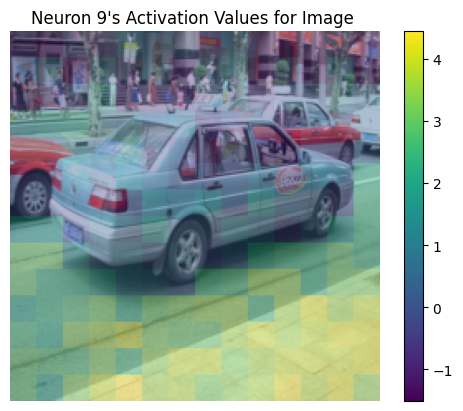

Class Name: cab
Activation Value: 2.318835973739624
Batch Index: 349



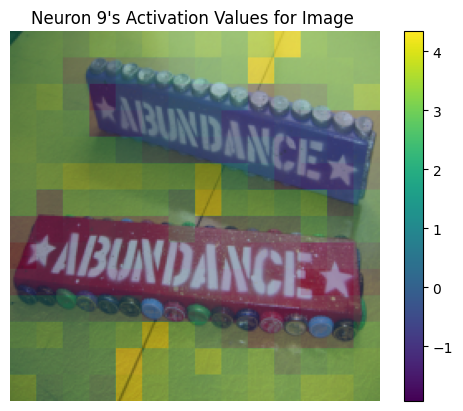

Class Name: bottlecap
Activation Value: 2.2292490005493164
Batch Index: 448



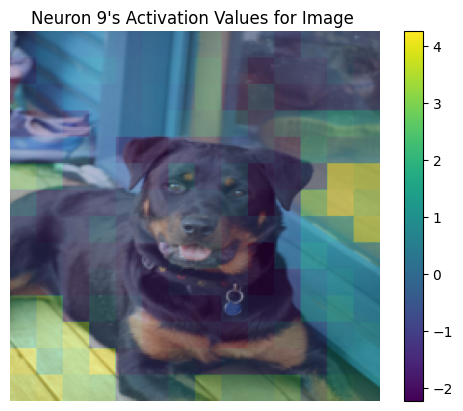

Class Name: Rottweiler
Activation Value: 2.1526732444763184
Batch Index: 335



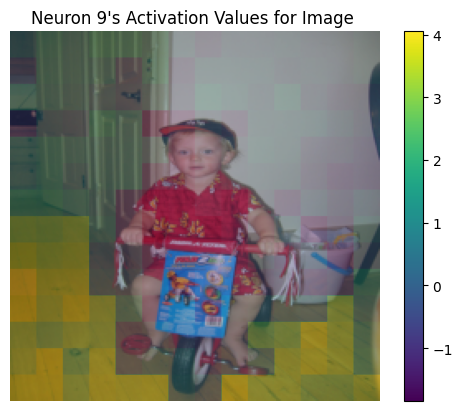

Class Name: tricycle
Activation Value: 1.975167989730835
Batch Index: 365



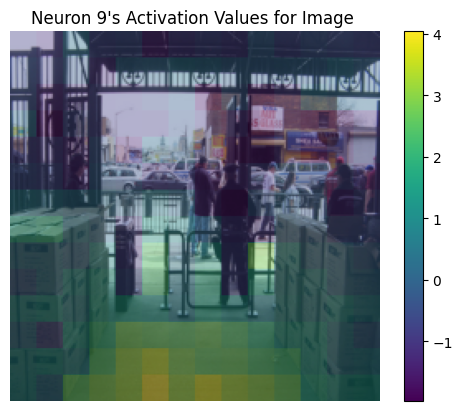

Class Name: turnstile
Activation Value: 1.96351957321167
Batch Index: 282



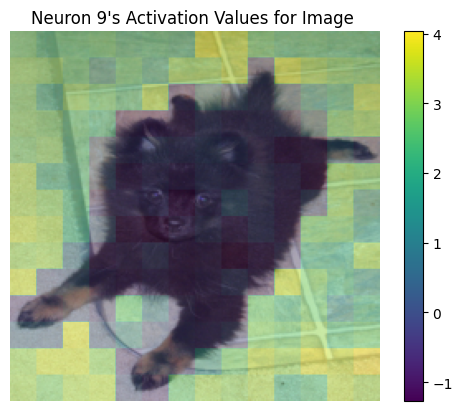

Class Name: Pomeranian
Activation Value: 1.9585654735565186
Batch Index: 305



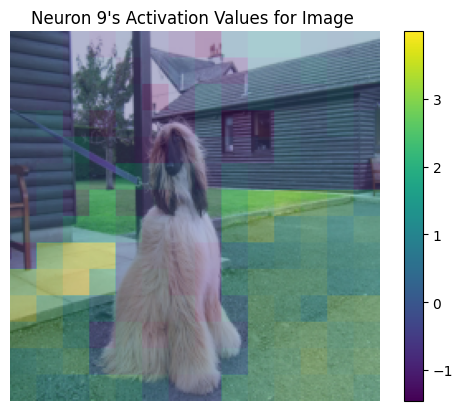

Class Name: Afghan_hound
Activation Value: 1.923245906829834
Batch Index: 424



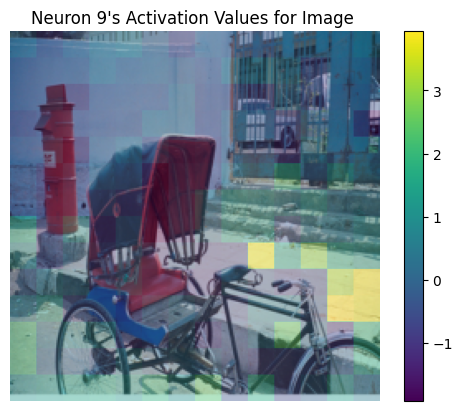

Class Name: jinrikisha
Activation Value: 1.87333083152771
Batch Index: 82



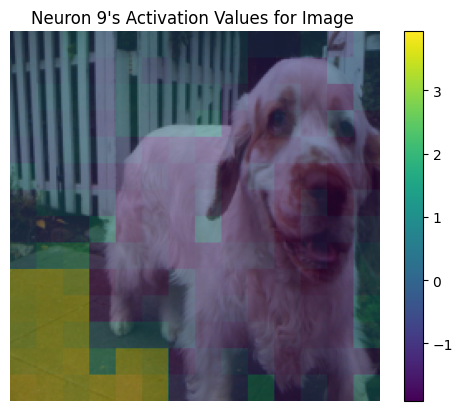

Class Name: clumber
Activation Value: 1.8669817447662354
Batch Index: 6



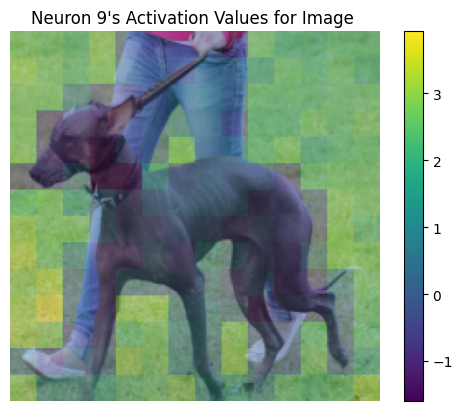

Class Name: Mexican_hairless
Activation Value: 1.8622280359268188
Batch Index: 130



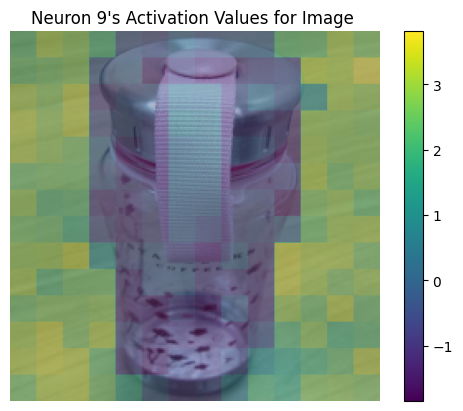

Class Name: water_jug
Activation Value: 1.7586191892623901
Batch Index: 479



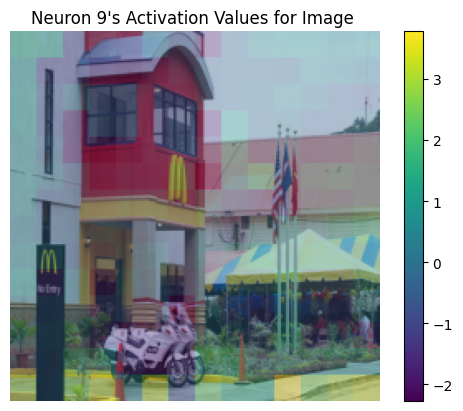

Class Name: flagpole
Activation Value: 1.7350767850875854
Batch Index: 332



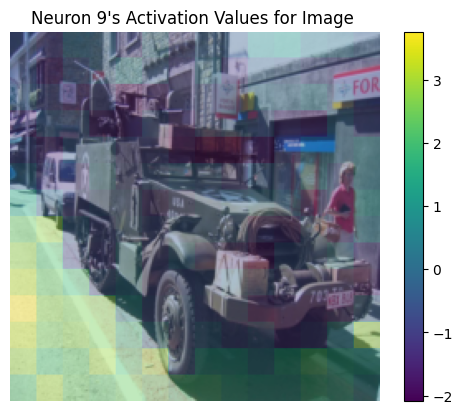

Class Name: half_track
Activation Value: 1.7174421548843384
Batch Index: 377



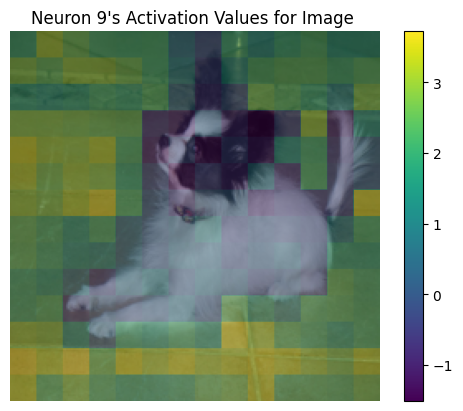

Class Name: papillon
Activation Value: 1.6846002340316772
Batch Index: 229



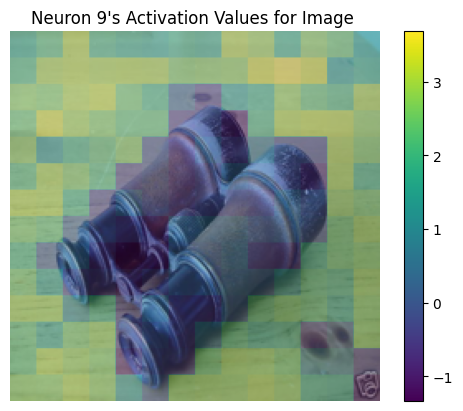

Class Name: binoculars
Activation Value: 1.6532938480377197
Batch Index: 67



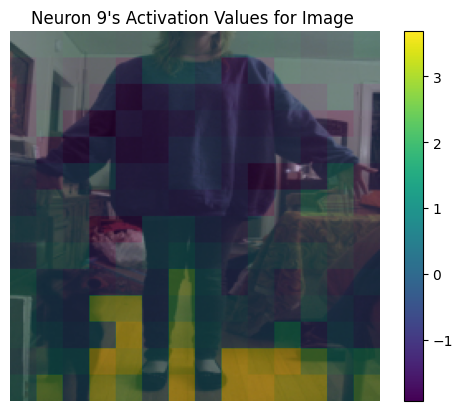

Class Name: sweatshirt
Activation Value: 1.6462067365646362
Batch Index: 139



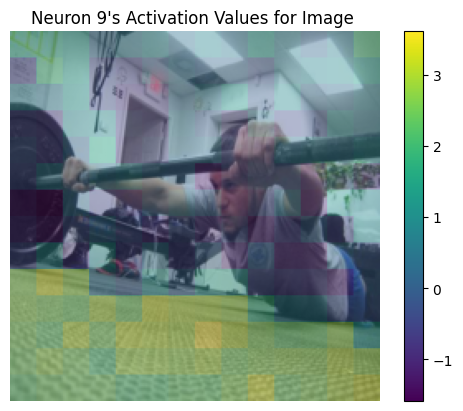

Class Name: barbell
Activation Value: 1.5812199115753174
Batch Index: 35



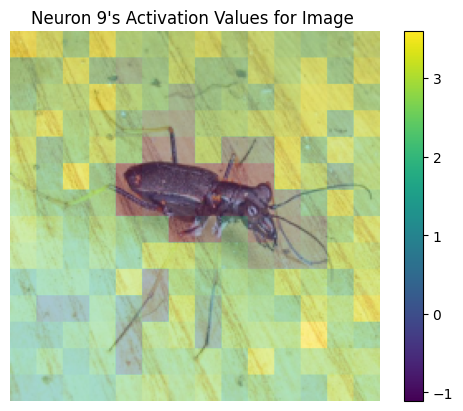

Class Name: ground_beetle
Activation Value: 1.5707290172576904
Batch Index: 23



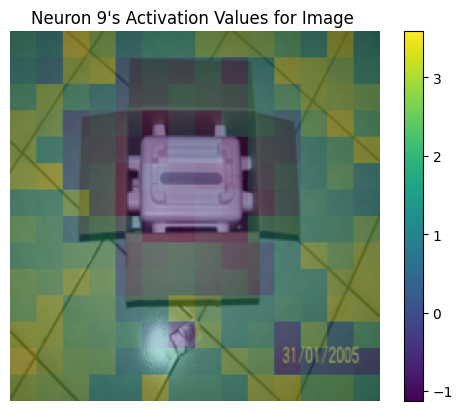

Class Name: carton
Activation Value: 1.564569354057312
Batch Index: 219



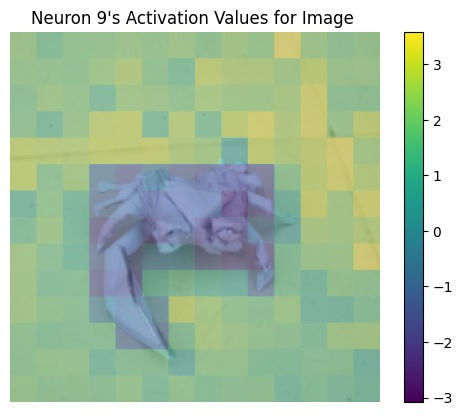

Class Name: fiddler_crab
Activation Value: 1.5586462020874023
Batch Index: 159



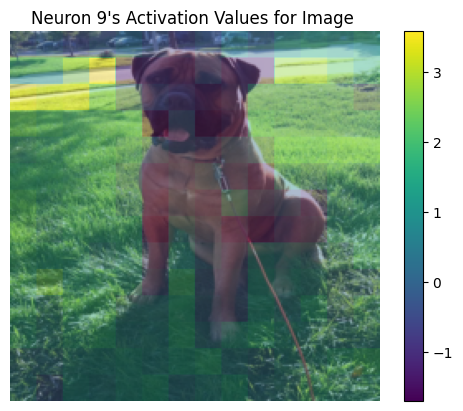

Class Name: bull_mastiff
Activation Value: 1.557791829109192
Batch Index: 361



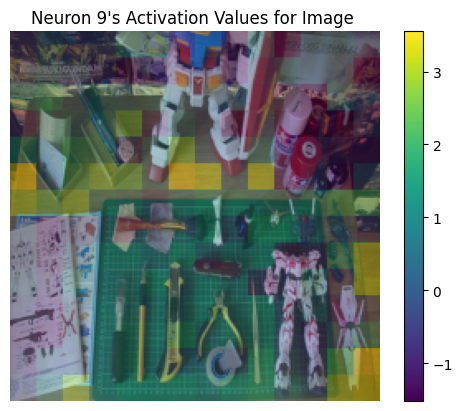

Class Name: carpenter's_kit
Activation Value: 1.5328439474105835
Batch Index: 256



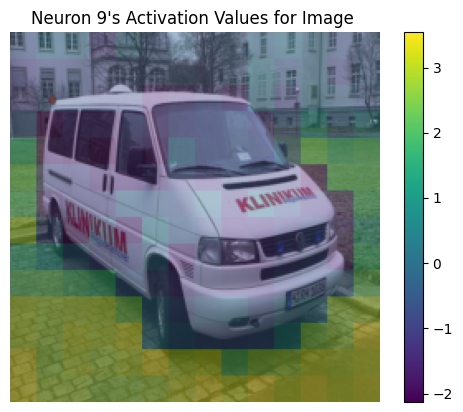

Class Name: ambulance
Activation Value: 1.5238581895828247
Batch Index: 453



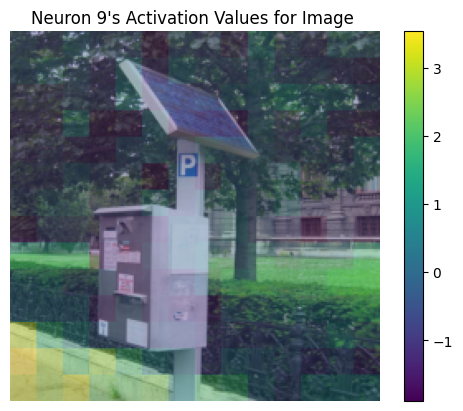

Class Name: parking_meter
Activation Value: 1.5181372165679932
Batch Index: 403



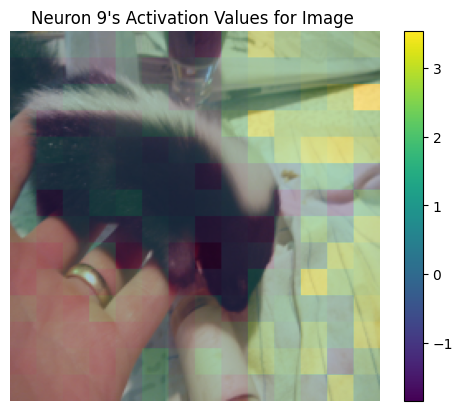

Class Name: skunk
Activation Value: 1.5160483121871948
Batch Index: 434



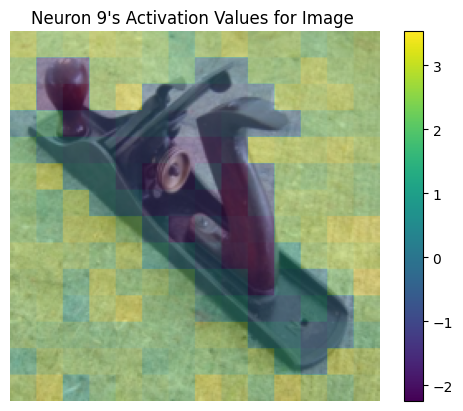

Class Name: plane
Activation Value: 1.5121228694915771
Batch Index: 258



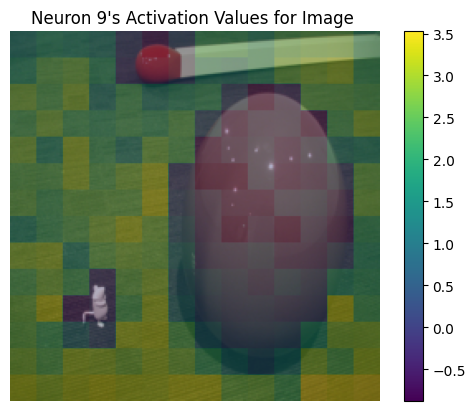

Class Name: matchstick
Activation Value: 1.509509801864624
Batch Index: 166



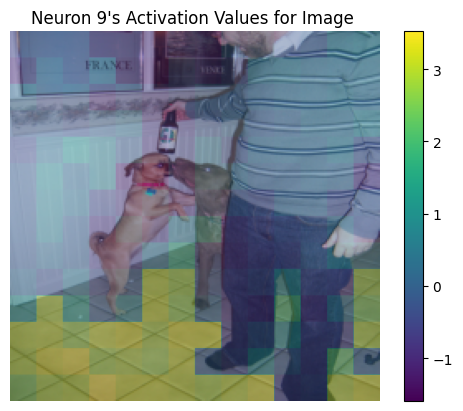

Class Name: Chesapeake_Bay_retriever
Activation Value: 1.5064913034439087
Batch Index: 291



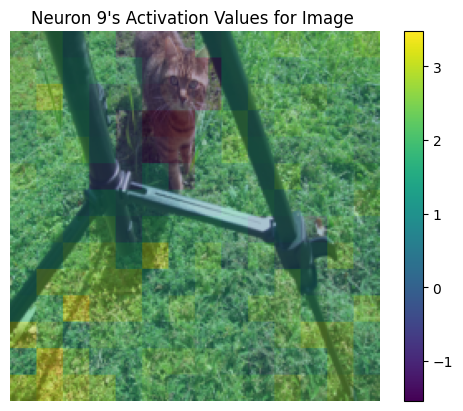

Class Name: tripod
Activation Value: 1.4652600288391113
Batch Index: 215



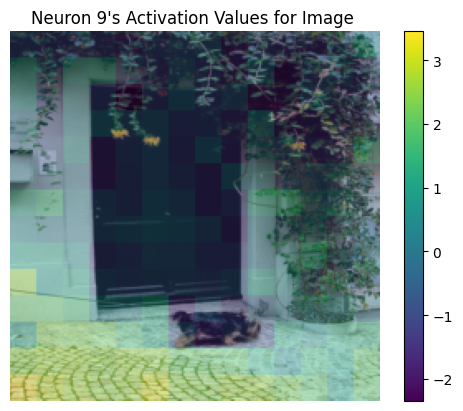

Class Name: silky_terrier
Activation Value: 1.4444687366485596
Batch Index: 440



In [20]:
# Get top 10 class names, no duplicates
import matplotlib.pyplot as plt

specific_neuron_idx = 9

unique_top_entries = sorted_df[sorted_df['neuron_idx'] == specific_neuron_idx].drop_duplicates(subset='class_name').head(30)

# Extracting class names and activation values
unique_top_class_names = unique_top_entries['class_name'].tolist()
unique_top_activations = unique_top_entries['activation_value'].tolist()
unique_top_batch_idx = unique_top_entries['batch_idx'].tolist()

# Lists are ready to use
print("Top 10 Unique Class Names:", unique_top_class_names)
print("Corresponding Activations:", unique_top_activations)
print("Corresponding Batch Indices:", unique_top_batch_idx)


# Now plot

for i, batch_idx in enumerate(unique_top_batch_idx):
    image, activation_values_array = get_image_and_activations_by_id(specific_neuron_idx, batch_idx)
    plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)
    print("Class Name:", unique_top_class_names[i])
    print("Activation Value:", unique_top_activations[i])
    print("Batch Index:", unique_top_batch_idx[i])
    print("")
# image, activation_values_array = get_image_and_activations_by_id(specific_neuron_idx, unique_top_batch_idx[0])
# plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)